In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
from model_utils import *

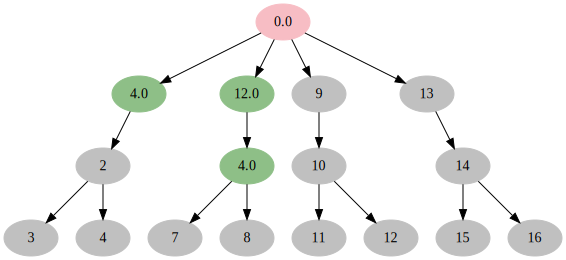

In [2]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

env = make_env(1.25)
env.reset()
for a in [1, 5, 6,]:
    env.step(a)
env.render()

# Linear softmax policy

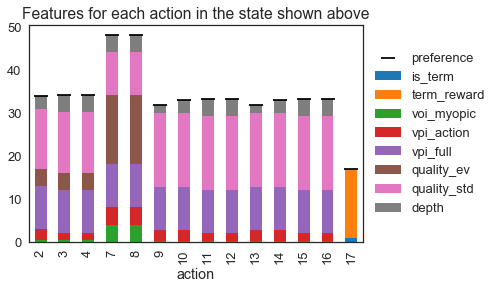

In [3]:
features = '''
is_term
term_reward
voi_myopic
vpi_action
vpi_full
quality_ev
quality_std
depth
'''.strip().split('\n')

from human_model import HumanPolicy

agent = Agent()
theta = np.ones(8)
pol = HumanPolicy(theta=theta, temp=1)
agent.register(env)
agent.register(pol)

actions = list(env.actions(env._state))
phi = [pol.phi(env._state, action)[:-1]
       for action in actions]

phi = pd.DataFrame(phi, index=actions, columns=features)
phi.plot.bar(stacked=True, legend=False)
plt.scatter(range(len(phi)), phi.sum(1), 
            c='k', marker='_', s=200, zorder=10, label='preference')
plt.axhline(0, c='k', lw=1)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('action')
plt.title('Features for each action in the state shown above')

# Optimize policy by evolution

In [312]:
from evolution import EvolutionaryOptimizer

envs = make_envs(1.25, n=100, ground_truth=17)

def x2theta(x):
    return np.r_[x[0], 1, 0, 0, 0, x[1:]]

def loss(x):
    return - get_util(HumanPolicy(x2theta(x)), envs)

bounds = np.array([
    (-30, 30), # is_term
    # (1, 1),   # term_reward
    # (0, 0),   # voi_myopic
    # (0, 0),   # vpi_action
    # (0, 0),   # vpi_full
    (0, 1),  # quality_ev
    (0, 1),  # quality_std
    (0, 1), # depth
]).T

opt = EvolutionaryOptimizer(loss, tuple(bounds), size=10, gen=20)
opt.evolve()
opt_theta = x2theta(opt.pop.champion_x)
pol = HumanPolicy(opt_theta)
print(opt_theta)

[-4.571  1.     0.     0.     0.     0.597  0.328  0.322]


# Simulate experiment

In [4]:
from analysis_utils import *
from agents import run_episode
df, pdf = load('1.8', base='exp-data')
COSTS = pdf.info_cost.unique()
env = None
# Load the reward structures used in the experiment.
def exp_envs():
    global env
    for cost in pdf.info_cost.unique():
        with open(f'exp-data/rewards_{cost:.2f}.json') as f:
            d = json.load(f)
            for kind in 'train', 'test':
                for t in d[kind]:
                    env = make_env(cost, ground_truth=t['stateRewards'])
                    trace = run_episode(read_bo_policy(cost), env)
                    yield {'cost': cost, 'trial_id': t['trial_id'], 'kind': kind, 'env': env,
                           'optimal_clicks': len(trace['actions']) - 1, 
                           'optimal_return': trace['return']}

exp_envs = pd.DataFrame(exp_envs())
exp_envs.drop('env', axis=1).set_index('trial_id').to_csv('data/exp_envs.csv')
exp_envs.groupby(['kind', 'cost']).optimal_return.mean()

kind   cost
test   0.10    20.383333
       1.25    18.541667
       4.00    -0.666667
train  0.10    19.800000
       1.25     9.250000
       4.00    -4.400000
Name: optimal_return, dtype: float64

In [6]:
# env.node_value_after_observe((15,), 0, env._state).expectation()
env.node_value_after_observe((16,), 0, env._state).expectation()

9.2858159279300505

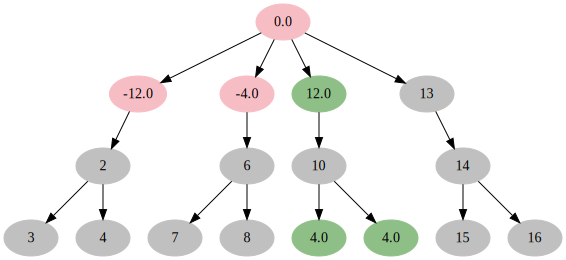

In [7]:
env.render()

In [ ]:
from agents import run_episode
run_episode(read_bo_policy())

In [314]:
label = Labeler()
def simulate(policy, envs, seed=None):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    agent = Agent()
    agent.register(ENV)
    agent.register(policy)
    for trial_id, env in envs.items():
        agent.register(env)
        trace = agent.run_episode()
        for s, a in zip(trace['states'], trace['actions']):
            yield {'pid': seed, 'cost': abs(env.cost), 'trial_id': trial_id,
                   'state': label(s), 'action': a}
        

alt_envs = dict(zip(range(100), make_envs(1.25, ground_truth=1)))
data = pd.DataFrame(simulate(pol, exp_envs))

# Fit human data

In [9]:
from analysis_utils import load
from model_utils import *
from toolz import *
from human_model import action_features

label = Labeler()
def expand():
    for i, row in df.iterrows():
        for s, a in zip(row.states, concatv(row.clicks, [ENV.term_action])):
            yield {'pid': row.pidx, 'cost': row.info_cost, 'pr_type': row.pr_type,
                   'state': label(parse_state(s)), 'action': a, 'trial_id': row.trial_id}

data = pd.DataFrame(expand())
data.head()

,action,cost,pid,pr_type,state,trial_id
0,1,1.25,0,none,0,8969
1,17,1.25,0,none,1,8969
2,5,1.25,0,none,0,9359
3,9,1.25,0,none,2,9359
4,1,1.25,0,none,3,9359


Likelihood:
$$p(D \mid \theta) = \prod_i^N p(a_i \mid s_i; \theta)$$

Softmax Q policy:
$$p(a \mid s; \theta) = \frac{\exp \{ Q(s, a; \theta) \} }{ \sum_{a'} \exp \{ Q(s, a'; \theta) \} }$$

Linear regression Q:
$$Q(s, a; \theta) = \theta^\top \phi(s, a)$$

Before performing inference, we precompute the features, storing them in a 3d tensor.
`phi[s, a, f]` will give the value $\phi(s, a)_f$


In [315]:
phi = np.array([[pol.phi(s, a) for a in range(env.term_action + 1)]
                 for s in label._xs])


In [318]:
def logp(data, theta, temp=1):
    theta = np.r_[theta, 1]
    Q = np.dot(phi[data.state.as_matrix()], theta)
    Q -= Q.max(1).reshape(-1, 1)  # prevent float overflow 
    idx = np.arange(len(data))
    eq = np.exp(Q / temp)
    chosen = eq[idx, data.action.as_matrix()]
    return np.log(chosen / eq.sum(1))
    

print('Predictive accuracy')
print('  true policy:', np.exp(logp(data, pol.theta, 1e-10).sum() / len(data)))
print('  random policy:', np.exp(logp(data, pol.theta, 1e10).sum() / len(data)))


# print(x[idx])
# print(x1[idx])

Predictive accuracy
  true policy: 0.495409810491
  random policy: 0.0849073939902


In [336]:
import pymc3 as pm
import theano.tensor as tt

def run_model(data):
    n_pid = data.pid.max() + 1
    n_feature = len(phi[0,0])
    idx = np.arange(len(data))
    state = data.state.as_matrix()
    action = data.action.as_matrix()
    # std = dict(zip(features, phi[state].std((0,1))))

    with pm.Model() as model:
        

        theta = tt.stack([
            pm.Normal('is_term', 0, 10 / std['is_term']),
            1,
            0, 0, 0,
            pm.Normal('quality_ev', 10 / std['quality_ev']),
            pm.Normal('quality_std', 10 / std['quality_std']),
            pm.Normal('depth', 0, 10 / std['depth']),
            1 # dummy coefficient
        ])
        
        temp = pm.Exponential('temp', 1)
        
        preference = tt.dot(phi[state], theta)
        preference -= preference.max(1).reshape((len(data), 1))  # numerical stability

        eq = tt.exp(preference / temp)
        chosen = eq[idx, action]
        
        logp = pm.Deterministic('log_likelihood', tt.log(chosen / (eq.sum(1) + 1e-40)))
        pm.Potential('_', logp.sum())

        return pm.sample(), model

trace, model = run_model(data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 999/1000 [01:32<00:00, 10.81it/s]/home/fredcallaway/miniconda3/envs/mcrl/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 138 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [01:32<00:00, 10.81it/s]


In [337]:
theta = pd.DataFrame({k: trace[k] for k in features if k in trace.varnames})

/home/fredcallaway/miniconda3/envs/mcrl/lib/python3.6/site-packages/pymc3/backends/base.py:297: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  warnings.warn("Attribute access on a trace object is ambigous. "


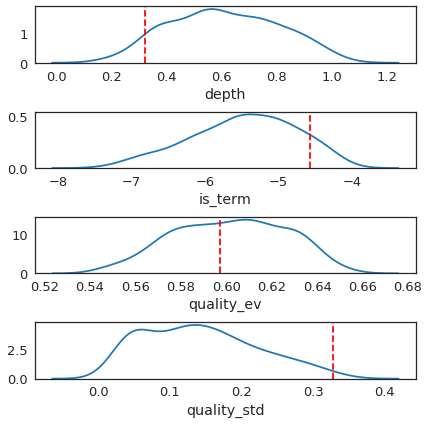

In [360]:
truth = dict(zip(features, pol.theta))
fig, axes = plt.subplots(len(theta.columns), figsize=(6, 6))
for k, ax in zip(theta, axes):
    plt.sca(ax)
    sns.distplot(theta[k], hist=0)
    plt.axvline(truth[k], c='r', ls='--')

plt.tight_layout()

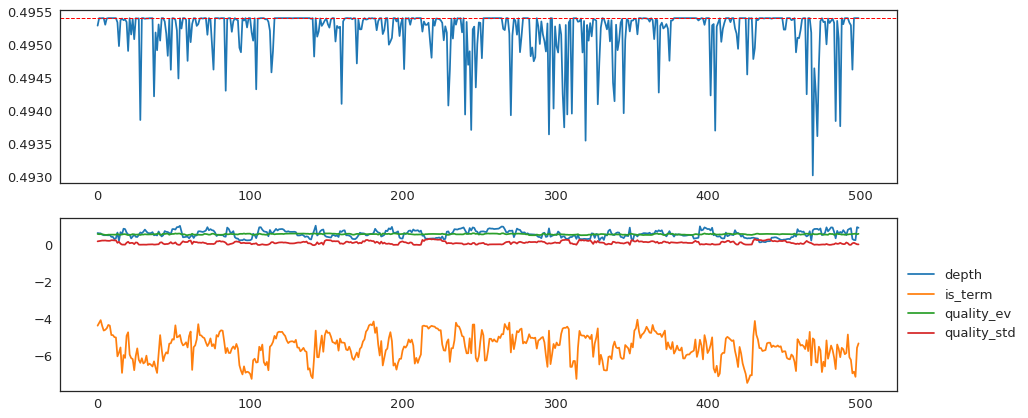

In [361]:
fig, ax = plt.subplots(2, figsize=(15,7))

plt.sca(ax[0])
plt.plot(np.exp(trace['log_likelihood'].mean(1)))
plt.axhline(np.exp(logp(data, pol.theta, temp=1e-9).mean()),
            c='r', ls='--', lw=1)

theta.plot(legend=False, ax=ax[1])
plt.sca(ax[1])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Text(0.5,1,'Correlations in θ samples')

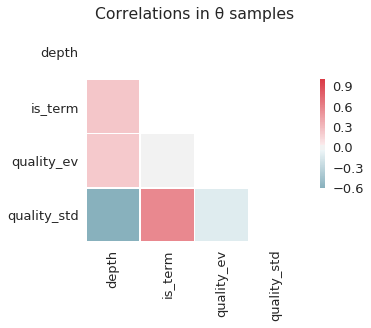

In [362]:
corr = theta.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations in θ samples')